# 1.Introduction 

This report presents the modeling of heat transfer in a copper beam using the finite difference method and boundary conditions applied at 10 cm from the left end and 50 cm from the right end. Heat transfer is a fundamental phenomenon encountered in various engineering applications, and understanding the temperature distribution in solid structures is crucial for designing efficient thermal systems.

The heat equation is a partial differential equation that describes how temperature changes over time in a given domain. In one dimension, the heat equation can be expressed as:

$$
    \kappa \frac{\partial^2{u}}{\partial{x}^2} = \frac{\partial{u}}{\partial{t}}
$$

where u(x, t) represents the temperature distribution along the beam at position x and time t, and α is the thermal diffusivity of the material.

In our case, we are considering the steady-state or time-independent heat equation. This means that the temperature distribution does not change with time, and the equation simplifies to:

$$
    \kappa \frac{\partial^2{u}}{\partial{x}^2} = 0
$$

We seek to solve this equation numerically using the finite difference method, which discretises the domain into dx intervals. The boundary conditions specify the temperatures at the ends of the beam, with a fixed temperature of 10°C at 0 cm from the left and 50°C at 80 cm from the right.

By solving the heat equation with these boundary conditions, we can determine the temperature profile along the copper beam. 

In [46]:
using BoundaryValueDiffEq
using Plots
using SparseArrays
using LinearAlgebra
using BenchmarkTools

# 2.Source Fonction 


In this part, I model a single force acting on the beam. To do this, I will create a function that takes the form of a Gaussian function with a maximum value A representing the magnitude of the force, a width represented by the parameter σ, and located at position X0 on the beam.


$$ f(x) = A\exp{(-\frac{(x-x_0)^2}{\sigma^2})} $$

For the heat equation, this force is actually a heat peak of magnitude A, width σ and located at position X0 on the beam. In this example, the heat peak is located 60 cm along the beam, with a narrow width.




In [47]:
function source_function(x)
    X0 = 60.0
    σ = 0.8
    A = 10.
    return  A .* exp.(.-((x .- X0).^2)./σ^2)
end

source_function (generic function with 1 method)

In [48]:
function source(N)
#Parameter
    l = 80.
    dx = l/N
#Mesh
    X_vect = Vector(0:dx:l)
# Function source
    f = source_function(X_vect)
    return f
end

source (generic function with 1 method)

# 3.Finite difference modelling.

The 1D time-independent heat equation is a mathematical model used to describe the distribution of heat in a one-dimensional medium over time.
$$\frac{\partial^2{u}}{\partial{x}^2} = 0$$
Where u represents the temperature distribution along the x-axis. To solve this equation numerically, we discretize the domain into small intervals dx and approximate the second derivative using finite differences.
$$
    \frac{\kappa(U_{i+1} -2U_{i} + U{i-1})}{dx^2} = 0
$$
With the boudarys conditions :

$$
    U_0 = 10\\
    U_N = 50
$$
This leads to a system of linear equations Au = b, where A is a tridiagonal matrix that represents the coefficients of the finite difference scheme, x is the vector containing the unknown temperature values at each discretized point. 
$$
A = \frac{\kappa}{dx^2} \begin{bmatrix}
1 & 0 & 0 & \dots & 0 \\
-1 & 2 & -1 & \dots & 0 \\
0 & -1 & 2 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & -1 & 2 \\
0 & 0 & \dots & 0 & 1 \\
\end{bmatrix}
$$

The vector b is is containing the known boundary conditions, so for this example the vector will be : 
$$
    \mathbf{b} = \begin{bmatrix} 10 \\ 0 \\ 0 \\ \vdots \\ 0 \\ 50\end{bmatrix}
$$

The heat source must be added to the linear system to get the real case. 

$$
    \mathbf{S} = \begin{bmatrix} f(0) \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ f(L)\end{bmatrix}
$$

So the linear system that we trying to solve is :

$$
   \fbox{ Au = b+S}
$$



Firstly, we will create the matrix A with the data used for a copper beam. We'll use the material density d, thermal conductivity tc and specifc heatsh. This will give : 
$$
    \kappa = \frac{tc}{sh \times d}
$$


In [49]:
function matrix(n) #8 times faster than before (calculate with @btime)

# Parameter for a copper bar 
    d= 8.92 #density 
    sh= 0.092 #specific_heat
    tc= 0.95 #thermal_conductivity
    l= 80 #length
    c = ( tc / (sh * d))^(1/2)
    dx = l/ n
    k = 1 #normally it's k = c²
    
# Build of the tridiagonal Matrix
    A = spdiagm(-1 =>  -(k / dx^2)* ones(n), 0 => 2 * (k / dx^2) * ones(n+1), 1 => - (k / dx^2) * ones(n)) 
    A[1,1] = 1
    A[1,2] = 0
    A[n+1,n+1] = 1 
    A[n+1,n] = 0
    return A
end

matrix (generic function with 1 method)

In [50]:
function heat(N)

#Parameter of the bar 
    l= 80 #length
    dx = l/ N  

# Build of the matrix A
    A = matrix(N)
    #print(A)

# Vector B from Au = B (Boundary)
    b = zeros(N+1)
    b[1] = 10
    b[end] = 50

# Vector S for the source power
    X_vect = Vector(0:dx:l)
    S = source_function(X_vect) 
    S[1] = 0                        #Not sure about this 
    S[end] = 0                      #Not sure about this 
                                    #Dont know if it's B[1] = 10 or S[1] + B[1] = U[1] = 50 same for n
    
# Solving of the Linear System
    u = A \ (b+S)   
    return u 
end 

heat (generic function with 1 method)

We also need to test the calculation time for this resolution. We can see that for a 1000x1000 matrix, the resolution time is fairly short.

In [51]:
@btime heat(1000)

  586.095 μs (118 allocations: 1.32 MiB)


1001-element Array{Float64,1}:
 10.0
 10.323592616144829
 10.647185232289658
 10.970777848434485
 11.294370464579313
 11.61796308072414
 11.941555696868967
 12.265148313013794
 12.58874092915862
 12.912333545303445
 13.23592616144827
 13.559518777593095
 13.88311139373792
  ⋮
 58.91855633278034
 58.10777848434576
 57.29700063591118
 56.486222787476606
 55.67544493904203
 54.86466709060746
 54.05388924217288
 53.243111393738296
 52.43233354530371
 51.621555696869144
 50.81077784843457
 50.0

# 4.Using BoundaryValueDiffEq from julia

Modeling with BoundaryValueDiffEq involves solving boundary value problems (BVPs) for differential equations in Julia. The BoundaryValueDiffEq package provides a comprehensive set of tools for solving BVPs, including a wide range of solvers and utilities.

To use BoundaryValueDiffEq, we define our BVP by specifying the differential equation, boundary conditions, and the domain or spatial range. The differential equation is typically defined as a function that calculates the derivatives of the dependent variables with respect to the independent variable(s). The boundary conditions define the values or relationships at the boundaries of the domain.

Once the BVP is defined, we create a BVProblem object, which encapsulates the differential equation, boundary conditions, and domain information. We can then use the solve() function to solve the BVP and obtain the solution.

BoundaryValueDiffEq supports various numerical methods for solving BVPs, including shooting methods, finite difference methods, and collocation methods. The choice of solver depends on the specific problem characteristics and requirements.

I will divide the programme into three parts : 

The first of which will explain the problem of diffusion. The problem can be explained in the same way as the heat equation.

$$
    \frac{\partial^2{u}}{\partial{x}^2} = - f \\
    \frac{\partial{u}}{\partial{x}} = U_2  = flux\\
    \frac{\partial^2{u}}{\partial{x}^2} = 0 - f
$$

The second part is the boundarys are explicited. Indeed, there are two boudarys conditions.

$$
    U(0) = 10\\
    U(L) = 50
$$

The last part is the resolution of the diffusion function and the boundarys function. As before, the parameters are those of an 80cm copper beam. With this programme, my result (sol1) is an N x 2 matrix, but to plot the solution, I only need the first term of each line. So I create a loop to obtain the solution vector sol2.



In [52]:
# Define diffusion equation using BoudaryValuDiffEq

In [53]:
function diffusion!(du, u, p, x)
    # u[1]: concentration 
    # u[2]: fluc 
    # d/dx(concentration)  = flux 
    du[1] = u[2]
    # d/dx(flux)  = sourceFct
    du[2] = 0 - source_function(x)
end    

diffusion! (generic function with 1 method)

In [54]:
# Define boundary conditions 

In [55]:
function boundaries!(residual, u, p, x)
    # residual boundary condition in the left end-point 
    residual[1] = u[1][1] - 10
    # residual boundary condition in the left end-point
    residual[2] = u[end][1] - 50
end 

boundaries! (generic function with 1 method)

In [56]:
# Set the boundary value problem to solve

In [57]:
function set_boundarys(N)
    
# define spatial range 
    xspan = (0.0, 80.)
    
# Parameter for a copper bar 
    d= 8.92 #density 
    sh= 0.092 #specific_heat
    tc= 0.95 #thermal_conductivity
    l = 80.
    dx = l/N
    xvec = Vector(0:dx:l)

    c = ( tc / (sh * d))^(1/2) 
    p = [c^2]; 
    
# set the boundary value problem to solve
    bvp1 = BVProblem(diffusion!, boundaries!, [10., 50.], xspan,p)

# set the boundary value problem  
    sol1 = solve(bvp1, GeneralMIRK4(), dt = 0.8)
    
# Take the first terme of every sublist for the first solution 
    sol2 = zeros(length(sol1))
    for i in 1:length(sol1)
        sol2[i] = sol1[i][1]  
    end
    return sol2
end

set_boundarys (generic function with 1 method)

We also need to test the calculation time for this resolution. We can see that for a 100 points, the resolution time is fairly short. But it is important to note that the finite difference mode is shorter.

In [58]:
@btime set_boundarys(100)

  258.184 ms (4920718 allocations: 385.84 MiB)


101-element Array{Float64,1}:
  10.0
  13.235828372690884
  16.471656745381768
  19.70748511807265
  22.943313490763536
  26.17914186345442
  29.4149702361453
  32.65079860883618
  35.886626981527066
  39.12245535421795
  42.35828372690884
  45.59411209959972
  48.8299404722906
   ⋮
 139.18233629879913
 131.0748511807265
 122.96736606265388
 114.85988094458126
 106.7523958265085
  98.64491070843587
  90.53742559036326
  82.42994047229062
  74.32245535421801
  66.21497023614525
  58.107485118072624
  50.0

# 5.Conclusion

In conclusion, the plots of the two methods are identical, and it can be seen that the source interferes with the solution of the heat equation, which is normal. However, using the finite difference method to solve the heat equation is better because of the reduced calculation time.
Moreover, the relative error between these two methods is around $2.10^{-3}$ maximum, which is another good point for the finite differential method.

In [59]:
#Set the Parameter N 

In [60]:
N = 100
l= 80.
dx = l/N

0.8

In [61]:
# Plot the computed solution: the source solution 

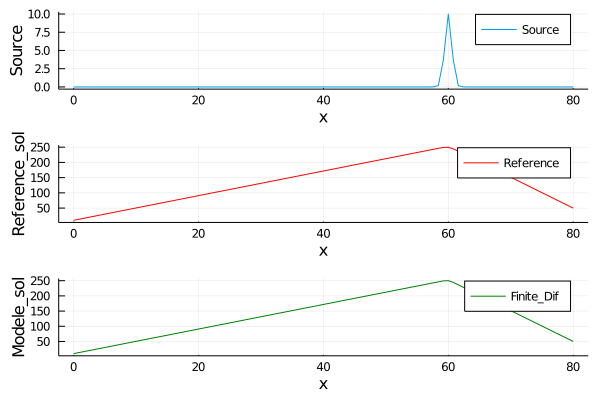

In [62]:
xvec = Vector(0:dx:l)
fvec = source_function.(xvec)

p1 = plot(xvec, fvec, label = "Source", xlabel = "x", ylabel = "Source")

p2 = plot(xvec, set_boundarys(N), label = "Reference", xlabel = "x", ylabel = "Reference_sol", linecolor = :red)

p3 = plot(xvec, heat(N), label = "Finite_Dif", xlabel = "x", ylabel = "Modele_sol", linecolor = :green)

plot(p1, p2, p3, layout = (3, 1))


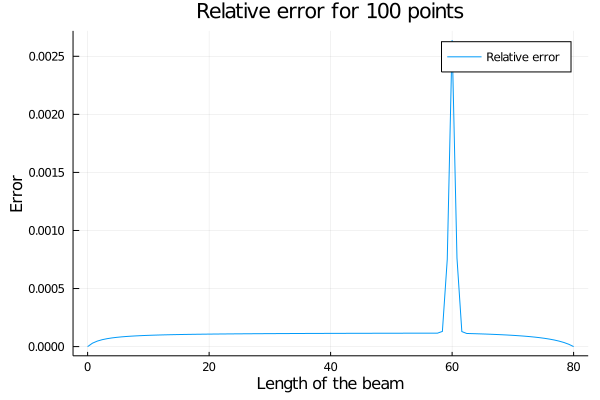

In [63]:
exact = set_boundarys(N)
modele = heat(N)
error = (abs.(exact .- modele) ./ exact) 
title = "Relative error for $N points"
plot(xvec, error, label = "Relative error", xlabel = "Length of the beam", ylabel = "Error", title = title)